# Tutorial

## Preliminaries

The following set of examples shows the user how to train a Masked Autoregressive Flow (MAF) and an example Kernel Density Estimator (KDE). We further demonstrate how to use *bayesstats* to estimate the Kullback Leibler divergence and Bayesian Dimensionality with the trained MAF and KDE.

The code requires [anesthetic](https://pypi.org/project/anesthetic/) to run.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from anesthetic.samples import NestedSamples

In order to demonstrate the applications of the code we need to load some example samples from a nested sampling run and we can visualise the posterior distributions with `anesthetic`. We write a helper function to load the chains and transform the parameters in the first three columns, which were generated with a log-uniform prior, into the unifrom parameter space.

*bayesstats* currently assumes that the parameters are uniformly distributed when calculating the KL divergence and bayesian dimensionality. It is therefore important to transform the parameters into the uniform parameter space before we train our MAF and KDE.

In [2]:
def load_chains(root):
    """
    Function uses anesthetic to load in a set of chains and returns
    the pandas table of samples, a numpy
    array of the parameters in the uniform space and weights.
    """

    samples = NestedSamples(root=root)

    try:
        names = ['p' + str(i) for i in range(ndims)]
        theta = samples[names].values
    except:
        names = [i for i in range(ndims)]
        theta = samples[names].values

    weights = samples.weights

    return samples, theta, weights

ndims=5

root = '../tests/test_samples/test'
samples, theta, weights = load_chains(root)


To visualise the posterior we define another helper function that will be useful later in the notebook.

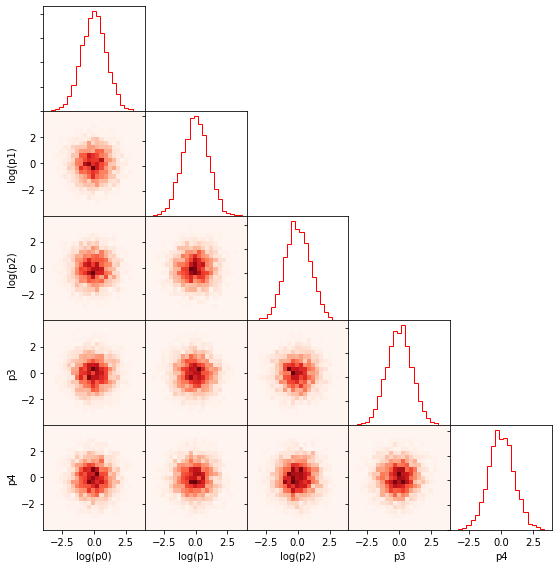

In [3]:
from anesthetic.plot import hist_plot_1d, hist_plot_2d

def plotter(theta, names, w=None, ndims=5):
    """ Helper function that uses anesthetic to produce corner plots """
    fig, axes = plt.subplots(ndims, ndims, figsize=(8, 8), sharex='col')
    for i in range(ndims):
        for j in range(ndims):
            if i < j:
                axes[i, j].axis('off')
            if i == j:
                hist_plot_1d(axes[i, j], theta[:, i], weights=w,
                xmin=theta[:, i].min(), xmax=theta[:, i].max(), color='r',
                histtype='step', bins=25, density=True)
            if i < j:
                hist_plot_2d(axes[j, i], theta[:, i], theta[:, j],
                            weights=w,
                            xmin=theta[:, i].min(), xmax=theta[:, i].max(),
                            ymin=theta[:, j].min(), ymax=theta[:, j].max(),
                            bins=25, density=True, cmap=plt.get_cmap('Reds'))
            if j not in set([0, ndims]):
                axes[i, j].set_yticklabels([])
            if j == 0:
                if i == 0:
                    axes[i, j].set_yticklabels([])
                else:
                    axes[i, j].set_ylabel(names[i])
            if i == ndims-1:
                axes[i, j].set_xlabel(names[j])
    plt.tight_layout()
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()

names = ['log(p' + str(i) + ')' if i in [0, 1, 2] else 'p' + str(i) for i in range(ndims)]
plotter(theta, names, weights)

## Masked Autoregressive Flows

Firstly we will look at training a Masked Autoregressive Flow or MAF with `bayesstats`. To train the MAF we first need to initalise the class with the samples and corresponding weights.

In [4]:
import os
os.chdir('../')

from bayesstats.maf import MAF

bij = MAF(theta, weights)
bij.train(100)

Epoch: 0 Loss: 0.0007236632
Epoch: 1 Loss: 0.00070656853
Epoch: 2 Loss: 0.0006889553
Epoch: 3 Loss: 0.0006711089
Epoch: 4 Loss: 0.00065313047
Epoch: 5 Loss: 0.00063506735
Epoch: 6 Loss: 0.00061694614
Epoch: 7 Loss: 0.0005987852
Epoch: 8 Loss: 0.0005805994
Epoch: 9 Loss: 0.0005624029
Epoch: 10 Loss: 0.0005442118
Epoch: 11 Loss: 0.000526045
Epoch: 12 Loss: 0.00050792674
Epoch: 13 Loss: 0.00048988743
Epoch: 14 Loss: 0.00047196637
Epoch: 15 Loss: 0.00045421295
Epoch: 16 Loss: 0.00043668825
Epoch: 17 Loss: 0.0004194658
Epoch: 18 Loss: 0.00040263258
Epoch: 19 Loss: 0.00038628906
Epoch: 20 Loss: 0.00037054575
Epoch: 21 Loss: 0.00035551866
Epoch: 22 Loss: 0.00034131674
Epoch: 23 Loss: 0.00032802264
Epoch: 24 Loss: 0.0003156741
Epoch: 25 Loss: 0.00030426422
Epoch: 26 Loss: 0.0002937718
Epoch: 27 Loss: 0.00028420804
Epoch: 28 Loss: 0.00027564922
Epoch: 29 Loss: 0.00026822375
Epoch: 30 Loss: 0.00026205485
Epoch: 31 Loss: 0.00025718394
Epoch: 32 Loss: 0.0002535229
Epoch: 33 Loss: 0.00025086358
Epo

We can then generate samples from the bijector using the following code which technically takes samples on the hypercube and transforms them into samples on the target posterior distribution,

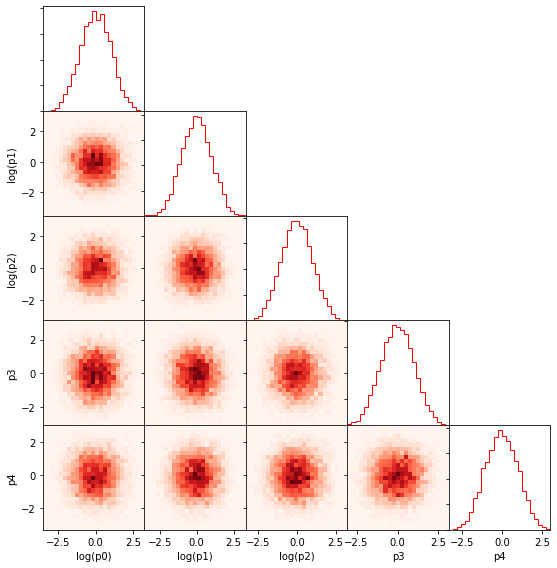

In [5]:
x = bij(np.random.uniform(0, 1, size=(len(theta), theta.shape[-1])))

plotter(x, names)

Alternatively we can generate samples with the following code which takes in an integer and returns an array of shape (int, 5). The `.sample()` function is a proxy for `__call__`.

In [6]:
x = bij.sample(5000)

We can then go ahead an calculate the corresponding kl divergence and Bayesian dimensionality. 

The samples presented here were generated using a gaussian likelihood and fitting with nested sampling for 5 parameters. We can use `anesthetic` to calculate the KL divergence and Bayesian dimensionality for the samples for comparison. We see very similar results and note that the similarity improves with the number of epochs.

In [7]:
from bayesstats.marginal_stats import maf_calculations

stats = maf_calculations(bij, x)
print(stats.klDiv(), samples.D())
print(stats.bayesian_dimensionality(), samples.d())

tf.Tensor(3.3165507, shape=(), dtype=float32) 3.3308079438366938
tf.Tensor(4.181942, shape=(), dtype=float32) 5.013952162478263


We could imagine that the above set of parameters is a sub-sample of perhaps signal parameters that we are interested in and having marginalised out the nuisance parameters we can use `bayesstats` to determine how well constrained the sub-space is.

As an example we can train a MAF on three of the parameters in this distribution.

Epoch: 0 Loss: 0.00043162625
Epoch: 1 Loss: 0.00041697096
Epoch: 2 Loss: 0.00040201913
Epoch: 3 Loss: 0.00038704174
Epoch: 4 Loss: 0.0003721551
Epoch: 5 Loss: 0.00035745723
Epoch: 6 Loss: 0.00034306958
Epoch: 7 Loss: 0.0003291606
Epoch: 8 Loss: 0.0003159566
Epoch: 9 Loss: 0.0003037277
Epoch: 10 Loss: 0.00029271413
Epoch: 11 Loss: 0.00028296578
Epoch: 12 Loss: 0.00027418995
Epoch: 13 Loss: 0.00026583258
Epoch: 14 Loss: 0.00025738275
Epoch: 15 Loss: 0.0002486456
Epoch: 16 Loss: 0.00023979602
Epoch: 17 Loss: 0.00023121592
Epoch: 18 Loss: 0.00022327917
Epoch: 19 Loss: 0.0002162135
Epoch: 20 Loss: 0.00021005911
Epoch: 21 Loss: 0.0002047087
Epoch: 22 Loss: 0.00020000151
Epoch: 23 Loss: 0.00019581053
Epoch: 24 Loss: 0.00019206767
Epoch: 25 Loss: 0.00018872511
Epoch: 26 Loss: 0.00018572956
Epoch: 27 Loss: 0.00018305895
Epoch: 28 Loss: 0.00018075563
Epoch: 29 Loss: 0.00017888586
Epoch: 30 Loss: 0.00017744435
Epoch: 31 Loss: 0.00017627429
Epoch: 32 Loss: 0.00017506914
Epoch: 33 Loss: 0.000173482

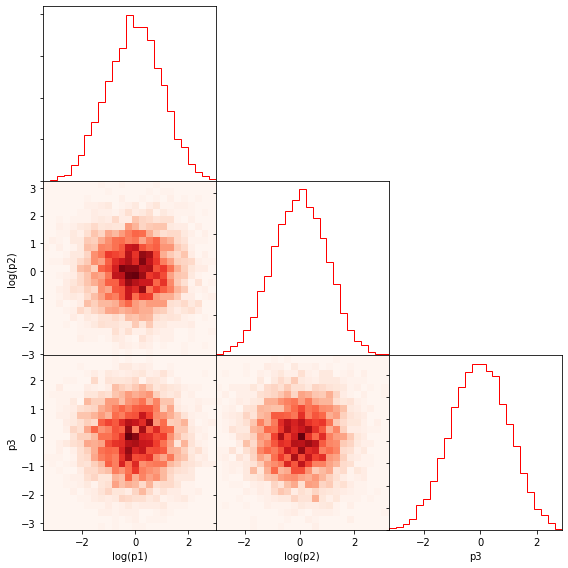

tf.Tensor(1.9865652, shape=(), dtype=float32)
tf.Tensor(2.555637, shape=(), dtype=float32)


In [8]:
theta_reduced = theta[:, 1:-1]
names_reduced = names[1:-1]

bij = MAF(theta_reduced, weights)
bij.train(100)
x = bij.sample(5000)

plotter(x, names_reduced, ndims=3)

stats = maf_calculations(bij, x)
print(stats.klDiv())
print(stats.bayesian_dimensionality())

# Kernel Density Estimators

We can perform a similar analysis using Kernel Density Estimators rather than MAFs which is done with the following code. Note that the generation of the 'trained' model is significantly quicker than when performed with the MAFs.

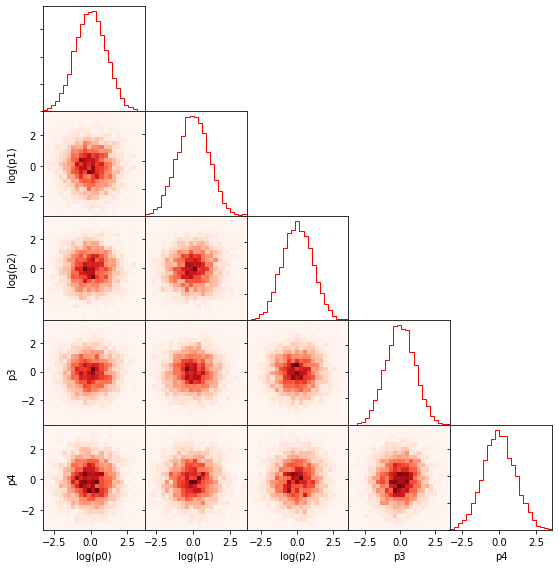

tf.Tensor(3.1464424, shape=(), dtype=float32) 3.3308079438366938
tf.Tensor(4.086628, shape=(), dtype=float32) 5.013952162478263


In [9]:
from bayesstats.kde import KDE
kde = KDE(theta, weights)
kde.generate_kde()
x = kde.sample(5000)

plotter(x, names)

from bayesstats.marginal_stats import kde_calculations

stats = kde_calculations(kde, x)
print(stats.klDiv(), samples.D())
print(stats.bayesian_dimensionality(), samples.d())

Rather than using the `kde.sample()` function to generate samples we could transform samples from the hypercube with the following code. However, we note that this is a much slower method of generating samples as it is designed to be bijective. Transformation from the hypercube is useful if we would like to use a trained KDE or MAF as the prior in a subseqeunt nested sampling run however is not necissary if we simply want to calcualte marginal Bayesian statistics.

In [10]:
x = kde(np.random.uniform(0, 1, size=(10, theta.shape[-1])))
print(x)

[[-0.11829965  1.27506803 -1.81180451  0.24690157 -0.00483511]
 [ 0.12916093 -1.05167247 -0.97871323  1.74080209 -0.83085717]
 [-0.16799171  0.58759295  0.13883955 -1.39876705  0.20187526]
 [-0.99995712  0.11730558  1.76906986  1.99542091 -0.21824603]
 [ 0.60131411 -1.58503205  0.01012616  0.41564238  0.84142974]
 [-0.19917245 -0.28667918 -0.50765469  0.18660712  0.55610343]
 [ 0.9444867  -0.1854406  -1.29777312 -0.03893257  0.18736033]
 [ 0.11583377 -0.23988482 -1.13781312 -1.28659515 -0.79895018]
 [ 1.32278833  0.63220892  0.92837153  2.76810487  1.32061413]
 [-0.46915435  1.9774634   1.60885825 -0.12722853 -1.55120167]]
